### 3D UNet for Image Segmentation in Digital Rock Petrophysics
#### Ahad Momin (ahadmomin16@gmail.com)
##### [GitHub](https://github.com/AhadMomin) | [Website](http://ahadmomin.github.io) |
#### Supervisor: Christoph Arns & Masa Prodanovic
#### Digital Rock Petrophysics

### 3D UNet:
#### The UNet Architecture is inspired by:  | [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) |

#### 2D UNet Model:




This deep neural network is implemented with Tensorflow and Keras functional API, which makes it extremely easy to experiment with different interesting architectures using GPU based enivronment


#### Import Required Packages

We will also need some standard packages. These should have been installed with Anaconda 3.

#### Load the required libraries

The following code loads the required libraries.

Some of the workflow Style is inspired by: Prof Micheal Pyrcz

In [3]:
import numpy as np                        # ndarrys for gridded data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
import seaborn as sns                     # for plotting
import warnings                           # supress warnings from seaborn pairplot
import cv2 
import random
import tensorflow as tf
import keras.backend as K
from keras.utils import to_categorical
import glob
import keras
from PIL import Image
import json
import os
import gc
from tqdm import notebook, tnrange
import tifffile as tiff
from sklearn.model_selection import train_test_split
import time
import datetime
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [4]:
os.chdir("/home/ahadmomin/project")

In [5]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probs of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

def iou_loss(true,pred):  #this can be used as a loss if you make it negative
    intersection = true * pred
    notTrue = 1 - true
    union = true + (notTrue * pred)

    return (K.sum(intersection, axis=-1) + K.epsilon()) / (K.sum(union, axis=-1) + K.epsilon())

def iou(y_true, y_pred, label: int):
    """
    Return the Intersection over Union (IoU) for a given label.
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
        label: the label to return the IoU for
    Returns:
        the IoU for the given label
    """
    # extract the label values using the argmax operator then
    # calculate equality of the predictions and truths to the label
    y_true = K.cast(K.equal(K.argmax(y_true), label), K.floatx())
    y_pred = K.cast(K.equal(K.argmax(y_pred), label), K.floatx())
    # calculate the |intersection| (AND) of the labels
    intersection = K.sum(y_true * y_pred)
    # calculate the |union| (OR) of the labels
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    # avoid divide by zero - if the union is zero, return 1
    # otherwise, return the intersection over union
    return K.switch(K.equal(union, 0), 1.0, intersection / union)


def build_iou_for(label: int, name: str=None):
    """
    Build an Intersection over Union (IoU) metric for a label.
    Args:
        label: the label to build the IoU metric for
        name: an optional name for debugging the built method
    Returns:
        a keras metric to evaluate IoU for the given label
        
    Note:
        label and name support list inputs for multiple labels
    """
    # handle recursive inputs (e.g. a list of labels and names)
    if isinstance(label, list):
        if isinstance(name, list):
            return [build_iou_for(l, n) for (l, n) in zip(label, name)]
        return [build_iou_for(l) for l in label]

    # build the method for returning the IoU of the given label
    def label_iou(y_true, y_pred):
        """
        Return the Intersection over Union (IoU) score for {0}.
        Args:
            y_true: the expected y values as a one-hot
            y_pred: the predicted y values as a one-hot or softmax output
        Returns:
            the scalar IoU value for the given label ({0})
        """.format(label)
        return iou(y_true, y_pred, label)

    # if no name is provided, us the label
    if name is None:
        name = label
    # change the name of the method for debugging
    label_iou.__name__ = 'iou_{}'.format(name)

    return label_iou
        

def mean_iou(y_true, y_pred):
    """
    Return the Intersection over Union (IoU) score.
    Args:
        y_true: the expected y values as a one-hot
        y_pred: the predicted y values as a one-hot or softmax output
    Returns:
        the scalar IoU value (mean over all labels)
    """
    # get number of labels to calculate IoU for
    num_labels = K.int_shape(y_pred)[-1]
    # initialize a variable to store total IoU in
    total_iou = K.variable(0)
    # iterate over labels to calculate IoU for
    for label in range(num_labels):
        total_iou = total_iou + iou(y_true, y_pred, label)
    # divide total IoU by number of labels to get mean IoU
    return total_iou / num_labels


smooth = 1.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [26]:
def create_numpyset(path_X ='/k',
                    path_y = '/k',
                    new_path_X= 'train_numpy/',
                    new_path_y='train_numpy/'):
    
    X=[]
    y=[]
    
    ids = next(os.walk(path_X))[1]
    print("Numnber of images = ", len(ids))    
    
    for n, id_ in notebook.tqdm(enumerate(ids), total=len(ids)):
        
        names_R=(path_X+id_+"/tomo/"+id_+".tif")
        names_y=(path_X+id_+"/seg/"+id_+".tif")
        print(names_R)
        print(names_y)
        tomo=tiff.imread(names_R)
        label= tiff.imread(names_y)
        X.append(tomo)
        y.append(label)
   
    X=np.array(X)
    X= X.astype(np.int64)
    xmax,xmin= X.max(),X.min()
    X= (X-xmin)/(xmax-xmin)
    y= to_categorical(y).astype(np.uint8)        
    X = np.expand_dims(X, axis=-1)
   
    print(X)
    print(X.shape)
    print(y)
    print(y.shape)    
        
    try:
        os.mkdir(new_path_X + '/X' )
        os.mkdir(new_path_y + '/y' )
    except: 
        print('folder exits')
    
    for im_num in range( np.shape(X)[0] ):
        np.save( new_path_X + '/X/' + f'{im_num}', X[im_num,:,:,:,:]  )
        np.save( new_path_y + '/y/' + f'{im_num}', y[im_num,:,:,:,:]  )

In [27]:
create_numpyset(path_X ='stage2_train3D/',
                    path_y = '/stage2_train3D',
                    new_path_X= 'train_numpy2/',
                    new_path_y='train_numpy2/')

Numnber of images =  18


stage2_train3D/0000/tomo/0000.tif
stage2_train3D/0000/seg/0000.tif
stage2_train3D/0001/tomo/0001.tif
stage2_train3D/0001/seg/0001.tif
stage2_train3D/0002/tomo/0002.tif
stage2_train3D/0002/seg/0002.tif
stage2_train3D/0003/tomo/0003.tif
stage2_train3D/0003/seg/0003.tif
stage2_train3D/0004/tomo/0004.tif
stage2_train3D/0004/seg/0004.tif
stage2_train3D/0005/tomo/0005.tif
stage2_train3D/0005/seg/0005.tif
stage2_train3D/0006/tomo/0006.tif
stage2_train3D/0006/seg/0006.tif
stage2_train3D/0007/tomo/0007.tif
stage2_train3D/0007/seg/0007.tif
stage2_train3D/0008/tomo/0008.tif
stage2_train3D/0008/seg/0008.tif
stage2_train3D/0009/tomo/0009.tif
stage2_train3D/0009/seg/0009.tif
stage2_train3D/0010/tomo/0010.tif
stage2_train3D/0010/seg/0010.tif
stage2_train3D/0011/tomo/0011.tif
stage2_train3D/0011/seg/0011.tif
stage2_train3D/0012/tomo/0012.tif
stage2_train3D/0012/seg/0012.tif
stage2_train3D/0013/tomo/0013.tif
stage2_train3D/0013/seg/0013.tif
stage2_train3D/0014/tomo/0014.tif
stage2_train3D/0014/seg/0014

In [28]:
num_gpus =3
total_samples=18
batch_size=1
epochs =375
train_ids = np.arange(0, total_samples)
image_dims = (128,128,128)
filters_first_layer = 64
## Validation Data Size
val_data_size = 263
validation_split=0.2
file_loc= 'train_numpy2/'

In [29]:
all_dirs = glob.glob(file_loc + '/X/*.npy')

X_train = np.zeros((len(all_dirs),image_dims[0],image_dims[1],image_dims[2],3)).astype(np.float32)
y_train = np.zeros((len(all_dirs),image_dims[0],image_dims[1],image_dims[2],4)).astype(np.int8)

for im_num in notebook.tqdm(range( len(all_dirs) )):
    
    X_train[im_num,:,:,:] = np.load( file_loc + f'/X/{im_num}.npy' )
    y_train[im_num,:,:,:] = np.load( file_loc + f'/y/{im_num}.npy' )

In [30]:
print(X_train,y_train)

[[[[[0.36477688 0.36477688 0.36477688]
    [0.373273   0.373273   0.373273  ]
    [0.39407656 0.39407656 0.39407656]
    ...
    [0.35898048 0.35898048 0.35898048]
    [0.3326981  0.3326981  0.3326981 ]
    [0.35596317 0.35596317 0.35596317]]

   [[0.19636334 0.19636334 0.19636334]
    [0.2197872  0.2197872  0.2197872 ]
    [0.24591075 0.24591075 0.24591075]
    ...
    [0.34929332 0.34929332 0.34929332]
    [0.35524854 0.35524854 0.35524854]
    [0.3488169  0.3488169  0.3488169 ]]

   [[0.10147689 0.10147689 0.10147689]
    [0.12855329 0.12855329 0.12855329]
    [0.12410672 0.12410672 0.12410672]
    ...
    [0.35064316 0.35064316 0.35064316]
    [0.3814515  0.3814515  0.3814515 ]
    [0.37668732 0.37668732 0.37668732]]

   ...

   [[0.3349214  0.3349214  0.3349214 ]
    [0.34699064 0.34699064 0.34699064]
    [0.329919   0.329919   0.329919  ]
    ...
    [0.36350644 0.36350644 0.36350644]
    [0.34564078 0.34564078 0.34564078]
    [0.35794824 0.35794824 0.35794824]]

   [[0.32515484 

In [31]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=2020)

In [32]:
print("Tomogram dimension in Training = ", X_train.shape,X_train.dtype)
print("Segmented dimension in Training  = ",y_train.shape, y_train.dtype)
print("Tomogram dimension in Testing = ",X_valid.shape, X_valid.dtype)
print("Segmented dimension in Testing = ",y_valid.shape, y_valid.dtype)

Tomogram dimension in Training =  (16, 128, 128, 128, 3) float32
Segmented dimension in Training  =  (16, 128, 128, 128, 4) int8
Tomogram dimension in Testing =  (2, 128, 128, 128, 3) float32
Segmented dimension in Testing =  (2, 128, 128, 128, 4) int8


Text(0.5, 1.0, 'Segmented(GR)')

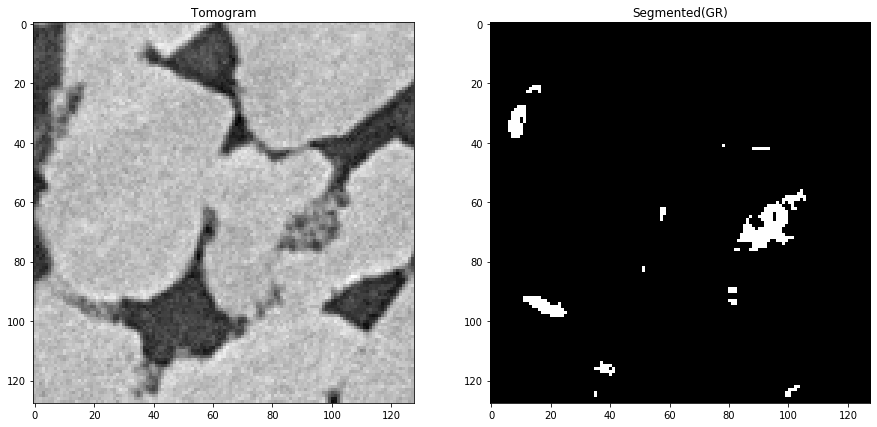

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))
ax1.imshow(X_train[1,1,...,1],cmap='gray')
ax1.set_title('Tomogram')
ax2.imshow((y_train[1,1,...,1]), cmap = 'gray')
ax2.set_title('Segmented(GR)')

Text(0.5, 1.0, 'Segmented(GR)')

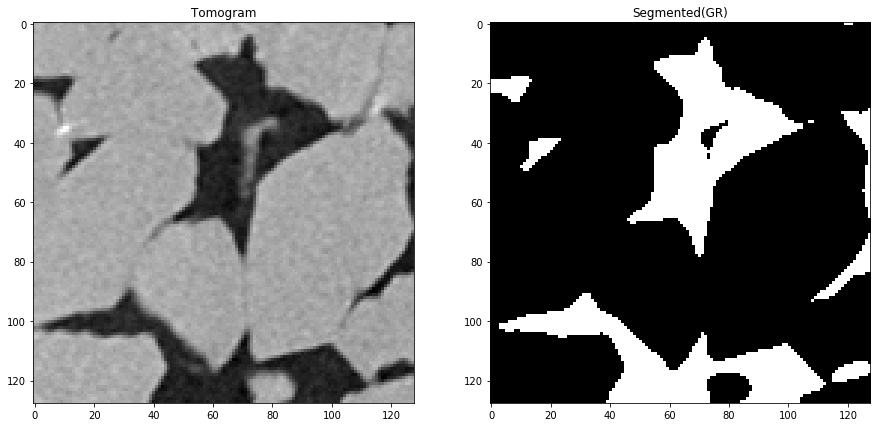

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))
ax1.imshow(X_train[3,1,...,0],cmap='gray')
ax1.set_title('Tomogram')
ax2.imshow((y_train[3,1,...,0]), cmap = 'gray')
ax2.set_title('Segmented(GR)')

Text(0.5, 1.0, 'Segmented(GR)')

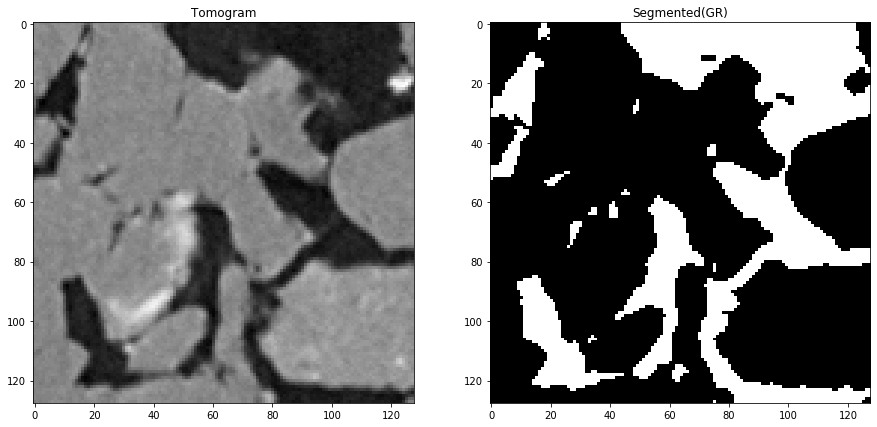

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 15))
ax1.imshow(X_valid[0,1,...,0],cmap='gray')
ax1.set_title('Tomogram')
ax2.imshow((y_valid[0,1,...,0]), cmap = 'gray')
ax2.set_title('Segmented(GR)')

In [36]:
# def batch_Norm_Activation(x, BN=False):
#     if BN == True:
#         x = keras.layers.BatchNormalization()(x)
#         x = keras.layers.Activation("relu")(x)
#     else:
#         x = keras.layers.Activation("relu")(x)
#     return x
# def Unet3D(featuremaps):
#     inputs = keras.engine.Input((image_dims[0],image_dims[1],image_dims[2],3 ))
#     #encoder
#     conv1 = keras.layers.Conv3D(featuremaps*1, (3,3,3),activation= None, padding = "same")(inputs)
#     conv1 = batch_Norm_Activation(conv1)
#     conv1 = keras.layers.Conv3D(featuremaps*1, (3,3,3),activation= None, padding = "same")(conv1)
#     conv1 = batch_Norm_Activation(conv1)
#     pool1  = keras.layers.MaxPooling3D((2,2,2))(conv1)
    
#     conv2 = keras.layers.Conv3D(featuremaps * 2, (3, 3 ,3), activation=None, padding="same")(pool1)
#     conv2 = batch_Norm_Activation(conv2)
#     conv2 = keras.layers.Conv3D(featuremaps * 2, (3, 3, 3), activation=None, padding="same")(conv2)
#     conv2 = batch_Norm_Activation(conv2)
#     pool2 = keras.layers.MaxPooling3D((2, 2, 2))(conv2)

#     conv3 = keras.layers.Conv3D(featuremaps * 4, (3, 3, 3), activation=None, padding="same")(pool2)
#     conv3 = batch_Norm_Activation(conv3)
#     conv3 = keras.layers.Conv3D(featuremaps * 4, (3, 3, 3), activation=None, padding="same")(conv3)
#     conv3 = batch_Norm_Activation(conv3)
#     pool3 = keras.layers.MaxPooling3D((2, 2, 2))(conv3)
    
#     conv4 = keras.layers.Conv3D(featuremaps * 8, (3, 3, 3), activation=None, padding ="same")(pool3)
#     conv4 = batch_Norm_Activation(conv4)
#     conv4 = keras.layers.Conv3D(featuremaps * 8, (3, 3, 3), activation=None, padding ="same")(conv4)
#     conv4 = batch_Norm_Activation(conv4)
#     pool4 = keras.layers.MaxPooling3D((2, 2, 2))(conv4)

#     # bridge
#     convm = keras.layers.Conv3D(featuremaps * 16, (3, 3, 3), activation=None, padding="same")(pool4)
#     convm = batch_Norm_Activation(convm)
#     convm = keras.layers.Conv3D(featuremaps * 16, (3, 3, 3), activation=None, padding="same")(convm)
#     convm = batch_Norm_Activation(convm)
    
#     #decoder
#     deconv4 = keras.layers.Conv3DTranspose(featuremaps* 8, (2, 2, 2), strides=(2,2,2), padding ="same")(convm)
#     uconv4 = keras.layers.concatenate([deconv4, conv4])
#     uconv4 = keras.layers.Conv3D(featuremaps* 8, (2 , 2, 2), activation = None, padding= "same")(uconv4)
#     uconv4 = batch_Norm_Activation(uconv4)
#     uconv4 = keras.layers.Conv3D(featuremaps* 8, (2 , 2, 2), activation = None, padding= "same")(uconv4)
#     uconv4 = batch_Norm_Activation(uconv4)

    
#     deconv3 = keras.layers.Conv3DTranspose(featuremaps * 4, (2, 2, 2), strides=(2, 2, 2), padding="same")(uconv4)
#     uconv3 = keras.layers.concatenate([deconv3, conv3])
#     uconv3 = keras.layers.Conv3D(featuremaps * 4, (2, 2, 2), activation=None, padding="same")(uconv3)
#     uconv3 = batch_Norm_Activation(uconv3)
#     uconv3 = keras.layers.Conv3D(featuremaps * 4, (2, 2, 2), activation=None, padding="same")(uconv3)
#     uconv3 = batch_Norm_Activation(uconv3)

    
#     deconv2 = keras.layers.Conv3DTranspose(featuremaps* 2, (2, 2, 2), strides = (2, 2, 2), padding= "same")(uconv3)
#     uconv2 = keras.layers.concatenate([deconv2, conv2])
#     uconv2 = keras.layers.Conv3DTranspose(featuremaps* 2, (2, 2, 2), activation = None, padding = "same")(uconv2)
#     uconv2 = batch_Norm_Activation(uconv2)
#     uconv2 = keras.layers.Conv3DTranspose(featuremaps* 2, (2, 2, 2), activation = None, padding = "same")(uconv2)
#     uconv2 = batch_Norm_Activation(uconv2)


#     deconv1 = keras.layers.Conv3DTranspose(featuremaps * 1, (2, 2 ,2), strides=(2, 2, 2), padding="same")(uconv2)
#     uconv1 = keras.layers.concatenate([deconv1, conv1])
#     uconv1 = keras.layers.Conv3D(featuremaps * 1, (2, 2, 2), activation=None, padding="same")(uconv1)
#     uconv1 = batch_Norm_Activation(uconv1)
#     uconv1 = keras.layers.Conv3D(featuremaps * 1, (2, 2,2), activation=None, padding="same")(uconv1)
#     uconv1 = batch_Norm_Activation(uconv1)

    
#     output_layer = keras.layers.Conv3D(4, (1, 1 ,1), padding="same", activation="softmax")(uconv1)
#     model = keras.models.Model(inputs, output_layer)
#     return model

In [37]:
def UResNet3D(featuremaps):
        inputs = keras.layers.Input(shape=(image_dims[0], image_dims[1], image_dims[2], 3))

        conv1 = keras.layers.Conv3D(featuremaps * 1, (3, 3,3), padding="same")(inputs)
        conv1 = batch_Norm_Activation(conv1)
        conv1 = keras.layers.Conv3D(featuremaps * 1, (3, 3,3), padding="same")(conv1)
        conv1 = batch_Norm_Activation(conv1)
        pool1 = keras.layers.MaxPooling3D((2, 2, 2))(conv1)

        conv2 = keras.layers.Conv3D(featuremaps * 2, (3, 3, 3), padding="same")(pool1)
        conv22 = batch_Norm_Activation(conv2)
        shortcut= keras.layers.Conv3D(featuremaps * 2, (3, 3, 3), padding="same")(conv22)
        shortcut= batch_Norm_Activation(shortcut)
        conv2 = keras.layers.Conv3D(featuremaps * 2, (3, 3, 3), padding="same")(conv22)
        conv2 = batch_Norm_Activation(conv2)
        conv2 = keras.layers.Conv3D(featuremaps * 2, (3, 3, 3), padding="same")(conv2)
        conv2 = batch_Norm_Activation(conv2)
        conv2 = keras.layers.add([shortcut, conv2])
        pool2 = keras.layers.MaxPooling3D((2, 2, 2))(conv2)

        conv3 = keras.layers.Conv3D(featuremaps * 4, (3, 3, 3), padding="same")(pool2)
        conv33 = batch_Norm_Activation(conv3)
        shortcut1= keras.layers.Conv3D(featuremaps * 4, (3, 3, 3), padding="same")(conv33)
        shortcut1= batch_Norm_Activation(shortcut1)
        conv3 = keras.layers.Conv3D(featuremaps * 4, (3, 3, 3), padding="same")(conv33)
        conv3 = batch_Norm_Activation(conv3)
        conv3 = keras.layers.Conv3D(featuremaps * 4, (3, 3, 3), padding="same")(conv3)
        conv3 = batch_Norm_Activation(conv3)
        conv3 = keras.layers.add([shortcut1, conv3])
        pool3 = keras.layers.MaxPooling3D((2, 2, 2))(conv3)
        
        
        conv4 = keras.layers.Conv3D(featuremaps * 8, (3, 3, 3), padding="same")(pool3)
        conv44 = batch_Norm_Activation(conv4)
        shortcut2= keras.layers.Conv3D(featuremaps * 8, (3, 3, 3), padding="same")(conv44)
        shortcut2= batch_Norm_Activation(shortcut2)
        conv4 = keras.layers.Conv3D(featuremaps * 8, (3, 3, 3), padding="same")(conv44)
        conv4 = batch_Norm_Activation(conv4)
        conv4 = keras.layers.Conv3D(featuremaps * 8, (3, 3, 3), padding="same")(conv4)
        conv4 = batch_Norm_Activation(conv4)
        conv4 = keras.layers.add([shortcut2, conv4])
        pool4 = keras.layers.MaxPooling3D((2, 2, 2))(conv4)


        convm = keras.layers.Conv3D(featuremaps * 16, (3, 3, 3), padding="same")(pool4)
        convm = batch_Norm_Activation(convm)
        shortcut3= keras.layers.Conv3D(featuremaps * 16, (3, 3, 3), padding="same")(convm)
        shortcut3= batch_Norm_Activation(shortcut3)
        convm = keras.layers.Conv3D(featuremaps * 16, (3, 3, 3), padding="same")(convm)
        convm = batch_Norm_Activation(convm)
        convm = keras.layers.Conv3D(featuremaps * 16, (3, 3, 3), padding="same")(convm)
        convm = batch_Norm_Activation(convm)
        convm = keras.layers.add([shortcut3, convm])

        deconv4 = keras.layers.Conv3DTranspose(featuremaps * 8, (2, 2, 2), strides=(2, 2, 2), padding="same")(convm)
        uconv4 = keras.layers.concatenate([deconv4, conv4])
        uconv4 = keras.layers.Conv3D(featuremaps * 8, (2, 2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)
        shortcut4= keras.layers.Conv3D(featuremaps * 8, (3, 3, 3), padding="same")(uconv4)
        shortcut4= batch_Norm_Activation(shortcut4)
        uconv4 = keras.layers.Conv3D(featuremaps * 8, (2, 2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)
        uconv4 = keras.layers.Conv3D(featuremaps * 8, (2, 2, 2), padding="same")(uconv4)
        uconv4 = batch_Norm_Activation(uconv4)
        uconv4 = keras.layers.add([shortcut4, uconv4])

        deconv3 = keras.layers.Conv3DTranspose(featuremaps * 4, (2, 2, 2), strides=(2, 2, 2), padding="same")(uconv4)
        uconv3 = keras.layers.concatenate([deconv3, conv3])
        uconv3 = keras.layers.Conv3D(featuremaps * 4, (2, 2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)
        shortcut5= keras.layers.Conv3D(featuremaps * 4, (3, 3, 3), padding="same")(uconv3)
        shortcut5= batch_Norm_Activation(shortcut5)
        uconv3 = keras.layers.Conv3D(featuremaps * 4, (2, 2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)
        uconv3 = keras.layers.Conv3D(featuremaps * 4, (2, 2, 2), padding="same")(uconv3)
        uconv3 = batch_Norm_Activation(uconv3)
        uconv3 = keras.layers.add([shortcut5, uconv3])

        deconv2 = keras.layers.Conv3DTranspose(featuremaps * 2, (2, 2, 2), strides=(2, 2, 2), padding="same")(uconv3)
        uconv2 = keras.layers.concatenate([deconv2, conv2])
        uconv2 = keras.layers.Conv3D(featuremaps * 2, (2, 2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)
        shortcut6= keras.layers.Conv3D(featuremaps * 2, (3, 3, 3), padding="same")(uconv2)
        shortcut6= batch_Norm_Activation(shortcut6)
        uconv2 = keras.layers.Conv3D(featuremaps * 2, (2, 2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)
        uconv2 = keras.layers.Conv3D(featuremaps * 2, (2, 2, 2), padding="same")(uconv2)
        uconv2 = batch_Norm_Activation(uconv2)
        uconv2 = keras.layers.add([shortcut6, uconv2])
        

        deconv1 = keras.layers.Conv3DTranspose(featuremaps * 1, (2, 2, 2), strides=(2, 2, 2), padding="same")(uconv2)
        uconv1 = keras.layers.concatenate([deconv1, conv1])
        uconv1 = keras.layers.Conv3D(featuremaps * 1, (2, 2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)
        shortcut7= keras.layers.Conv3D(featuremaps * 1, (3, 3, 3), padding="same")(uconv1)
        shortcut7= batch_Norm_Activation(shortcut7)
        uconv1 = keras.layers.Conv3D(featuremaps * 1, (2, 2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)
        uconv1 = keras.layers.Conv3D(featuremaps * 1, (2, 2, 2), padding="same")(uconv1)
        uconv1 = batch_Norm_Activation(uconv1)
        uconv1 = keras.layers.add([shortcut7, uconv1])


        output_layer = keras.layers.Conv3D(4, (1,1,1), padding="same", activation= 'softmax')(uconv1)
        model = keras.models.Model(inputs,output_layer)
        
        return model
def batch_Norm_Activation(x, BN=False): ## To Turn off Batch Normalization, Change BN to False >
    if BN == True:
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
    else:
        x= keras.layers.Activation("relu")(x)
    return x

In [38]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, 
                                              patience=55, 
                                              verbose=2, mode='auto', baseline=None,
                                              restore_best_weights=False),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=25,
                                  verbose=1, mode='auto', min_delta=0.0001, 
                                  cooldown=0, min_lr=0),
    keras.callbacks.ModelCheckpoint('model-3Dmyunet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [40]:
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = UResNet3D(32)
#     model = build_res_unet( input_shape  = ( 128,128,3 ), filters=filters_first_layer )
    metrics=[ 'accuracy', dice_coef, iou_loss, build_iou_for(label=0),build_iou_for(label=1),build_iou_for(label=2),build_iou_for(label=3), mean_iou] 
    model.compile( loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=1e-04), metrics=metrics[:])
model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 128 0                                            
__________________________________________________________________________________________________
conv3d_36 (Conv3D)              (None, 128, 128, 128 2624        input_2[0][0]                    
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 128, 128, 128 0           conv3d_36[0][0]                  
_____________________________________________________________________________________________

In [41]:
##    # This adds weight (attention) for balancing classes
from sklearn.utils.class_weight import compute_class_weight
  
def sample_weight(y):
        y_integers    = np.argmax(y, axis=4)
        class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers.flatten() )
        print(class_weights)
        d_class_weights = dict(enumerate(class_weights))
    
        sample_weight = np.zeros((np.shape(y_integers)[0])) 
        for sample in range(np.shape( sample_weight)[0] ):
            frac_0 = np.sum( y_integers[sample,:,:,:]==0 )/np.size(y_integers[sample,:,:,:])
            frac_1 = np.sum( y_integers[sample,:,:,:]==1 )/np.size(y_integers[sample,:,:,:])
            frac_2 = np.sum( y_integers[sample,:,:,:]==2 )/np.size(y_integers[sample,:,:,:])
            frac_3 = np.sum( y_integers[sample,:,:,:]==3 )/np.size(y_integers[sample,:,:,:])
    
            sample_weight[sample] = frac_0*d_class_weights[0]+frac_1*d_class_weights[1]+frac_2*d_class_weights[2]+ \
                                    frac_3*d_class_weights[3]
        return sample_weight




In [ ]:
hist_model = model.fit( x=X_train, y=y_train, epochs=epochs, batch_size=batch_size,
                       validation_data = (X_valid, y_valid, sample_weight(y_valid)), verbose=1, 
                       callbacks=callbacks, 
                       sample_weight=sample_weight(y_train),
                       shuffle=True )

[ 1.07266264 21.29390979  0.33282907 61.60122195]
[ 1.21964971 17.22375918  0.32134841 98.56195512]
Train on 16 samples, validate on 2 samples
Epoch 1/375
16/16 [==============================] - 32s 2s/step - loss: 0.5298 - accuracy: 0.7500 - dice_coef: 0.2771 - iou_loss: 0.1613 - iou_0: 0.2030 - iou_1: 6.1944e-06 - iou_2: 0.0182 - iou_3: 0.3750 - mean_iou: 0.1490 - val_loss: 0.4329 - val_accuracy: 0.7248 - val_dice_coef: 0.3864 - val_iou_loss: 0.2416 - val_iou_0: 0.2185 - val_iou_1: 0.0000e+00 - val_iou_2: 0.2025 - val_iou_3: 0.0000e+00 - val_mean_iou: 0.1052

Epoch 00001: val_loss improved from inf to 0.43290, saving model to model-3Dmyunet.h5
Epoch 2/375
16/16 [==============================] - 23s 1s/step - loss: 0.3457 - accuracy: 0.8417 - dice_coef: 0.5311 - iou_loss: 0.3903 - iou_0: 0.0553 - iou_1: 0.0000e+00 - iou_2: 0.6539 - iou_3: 0.3750 - mean_iou: 0.2711 - val_loss: 0.3281 - val_accuracy: 0.8716 - val_dice_coef: 0.6619 - val_iou_loss: 0.5673 - val_iou_0: 0.0034 - val_iou_1

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Learning curve")
plt.plot(hist_model.history["loss"], label="loss(Test)")
plt.plot(hist_model.history["val_loss"], label="val_loss(Train)")
plt.plot(hist_model.history["iou_loss"], label="iou_loss(Test)")
plt.plot(hist_model.history["val_iou_loss"], label="val_iou_loss(Test)")
plt.plot(np.argmin(hist_model.history["val_loss"]), np.min(hist_model.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("logloss")
plt.legend();

In [ ]:
model.load_weights('model-3Dmyunet.h5')
preds_train =np.argmax(model.predict(X_train[0:2], verbose=1),axis=4)
preds_test = np.argmax(model.predict(X_valid[0:2], verbose=1),axis=4)
print(preds_train.shape,preds_test.shape)

In [ ]:
plt.imshow(X_valid[1,2,...,1], cmap='gray')

In [ ]:
plt.imshow((y_valid[1,2,...,0]), cmap = 'gray')

In [ ]:
pre1= preds_test[1,:,:,:]
plt.imshow(pre1[2,:,:], cmap='gray')
print(preds_test)